In [ ]:
# Only need to run me once per session!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install onnxruntime

     |████████████████████████████████| 5.2 MB 8.0 MB/s 


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import cv2
import numpy as np
import io
import urllib, base64
from matplotlib import pyplot
import matplotlib.pyplot as plt
from math import sqrt
import onnxruntime

In [ ]:
# DUMMY DATA

df = pd.read_csv('/content/drive/MyDrive/Senioritis/Algorithm/Notebooks/train_mood_features.csv')
num_classes = 8
df = df.sample(frac=1).reset_index(drop=True)
col_features = df.columns[6:]
df = df.sample(frac=1) # Sample has random_state param to allow for reproducable results
data = df[col_features]

In [ ]:
# GLOBALS 
num_classes = 8
latent_dim = 128

In [ ]:
# Assuming song_features is a batch, 10 size feature matrix

# ['amusement', 'anger', 'awe', 'contentment', 'disgust', 'excitement', 'fear', 'sadness']

# REMOVE ME

def save_plot(examples, n_examples, path):
    # plot images
    plt.figure(figsize=(5,5))
    examples = examples.astype(np.uint8)
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[:, :, :])
    pyplot.savefig(path)
    pyplot.show()
    pyplot.close()

# Converts to one hot and finds the dominant mood

def findMost(labels):
  pred = []
  temp = (labels).copy()
  for x in range(0,len(labels)):
    temp[x] = np.argmax(temp[x], axis=0)
    pred.append((temp[x][0]))
  most = np.array(pred) 
  vals, counts = np.unique(most, return_counts=True)
  index = np.argmax(counts)
  return vals[index]

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_class):
    labels = np.eye(num_classes)[n_class.astype(np.int8)]
    noise = np.random.normal(size=(1, latent_dim))
    return np.concatenate((noise, [labels]), 1).astype(np.float32)

def generateImage(song_features):

  # ANN SECTION

  data_scaler = MinMaxScaler().fit(song_features)
  scaled_data = data_scaler.transform(song_features)
  session_s2m = onnxruntime.InferenceSession('/content/drive/MyDrive/Senioritis/Algorithm/song-to-moods.onnx')
  s2m_inputs = session_s2m.get_inputs()[0].name 
  onehot_moods = session_s2m.run([], {s2m_inputs: scaled_data.astype(np.float32)})[0]
  n_class = findMost(onehot_moods)

  # CGAN SECTION
  latent_dim = 128
  noise_and_labels = generate_latent_points(latent_dim, n_class)
  session_gen = onnxruntime.InferenceSession('/content/drive/MyDrive/Senioritis/Algorithm/generator.onnx')
  gen_inputs = session_gen.get_inputs()[0].name 
  img = session_gen.run([], {gen_inputs: noise_and_labels})[0]
  save_plot(np.squeeze(img,axis=0)*255, 1, 'test')
  img = img.astype(np.float32)
  img = np.transpose(img, (0, 3, 1, 2))

  # UPSCALER SECTION

  session_sr = onnxruntime.InferenceSession('/content/drive/MyDrive/Senioritis/Algorithm/RealESRGAN_x2plus.onnx')
  sr_inputs = session_sr.get_inputs()[0].name
  sr_img = session_sr.run([], {sr_inputs: img})[0]

  sr_img = np.clip(sr_img, a_min=0, a_max=1)
  sr_img = np.squeeze(sr_img,axis=0)

  sr_img = np.transpose(sr_img[[2, 1, 0], :, :], (1, 2, 0))

  sr_img = (sr_img * 255.0).round().astype(np.uint8)

  sr_img = cv2.cvtColor(sr_img, cv2.COLOR_BGR2RGB)

  buf = io.BytesIO()
  plt.imsave(buf, (sr_img), format='png')
  buf.seek(0)
  string = base64.b64encode(buf.read())

  uri = 'data:image/png;base64,' + urllib.parse.quote(string)

  return uri

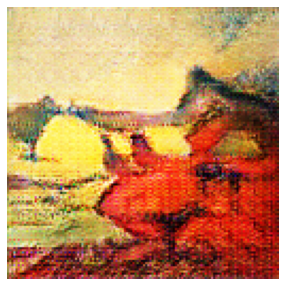

In [ ]:
res = generateImage(data)

In [ ]:
res

'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAYAAABccqhmAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD%2BnaQAAIABJREFUeJxUvc2SJEmOrfcBUDVzj4isrO6ee%2BeSIlxQhEIu%2BZJ8Fb4CH4YbCrm5cjkz3V35E%2B5mqgpwAZhnsbqrqzozw91MTRU4OOcAJv/H//6/xe23zvttQwmaKdttA4FmcN86rQlrDcwMFSHcEQnCnTUPhjutdUwUAFFDFXw5CIBh20azhoQgqiyHCAcEIvJvIAgIpzVFIhjzBDEQQ1RRMUQNAdYYmIKE4xGoGe6BmCIIhBMEsaBtO2oNEEwNdyfcCVZ9fbCWo2pggsSCcHxNQAlXsB2xjohhCrEGgiM4UPciQi6DIAgRgYch2hFrSK1RRCAaxBz4GkQsfC3UhGBBLBRnrQGiRBhIR9od8orw%2Bn5iIYBqAIHEYq2VP4fgGGhDVfJxuCOS1%2BBO/jkXgkBVmWMgsnA/ifUkfKCa1%2B6ez0lw1pq4n7lOvpDIZ7qmo%2BrMcyEC02fuHRXw/N5gESgrIj/N87uXO8sBVcbwXCuHCKFtOyGGaGOtyfl8MucAHEUYYyAqiCit9VzrgDVPAljh%2BIQ4R66fOE6gJhCLuSZrKsMbrje2%2B29MN/7fb3/w85zEfuP%2B/i98/fo7SvAf//X/hnng48AkEAyN3ONmIDH55/d/st12FGjhmCl62znmgHNyng/meeBjEDT6/s5%2Bv7PtN/Zb5xifjDFY03m/33i//YaosHCec%2BY%2B8oGKM%2BcTE8Osce/G%2B74hKP/%2BH3/neDxwd9rWiLbTevB//Z/fae2%2BeL990HtjrVyoiAAck1YHMw%2BNAIKiKngsli9mbQgW0BVVBQH3xVoTNDAxYgUhQUhuwPyiig9I/rceHuG5kXzh4XnoxVDNv0E